In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
from math import isfinite

# ---------- Define standardized price buckets ----------
std_bins = [0, 50, 100, 150, 200, np.inf]
std_labels = ['$0–50', '$51–100', '$101–150', '$151–200', '$201+']
std_edges = list(zip(std_bins[:-1], std_bins[1:]))

# ---------- Helper functions ----------
def parse_range(bucket_str):
    """Extract (low, high) from strings like '$12-$88' or '$698+'."""
    nums = re.findall(r'\d+', str(bucket_str).replace(',', ''))
    if len(nums) >= 2:
        return float(nums[0]), float(nums[1])
    elif len(nums) == 1:
        return float(nums[0]), np.inf
    else:
        return np.nan, np.nan

def allocate_proportionally(low, high, count, std_edges):
    """
    Allocate item counts proportionally into standard buckets
    based on overlap between original and standard price ranges.
    """
    allocations = np.zeros(len(std_edges), dtype=float)

    # If ranges invalid or 0
    if not (isfinite(high) and high > low):
        for i, (b_lo, b_hi) in enumerate(std_edges):
            if low >= b_lo and (low <= b_hi or b_hi == np.inf):
                allocations[i] = count
                return allocations
        allocations[0] = count
        return allocations

    # If prices on original bucket CSV file overlap the buckets defined
    for i, (b_lo, b_hi) in enumerate(std_edges):
        left = max(low, b_lo)
        right = min(high, b_hi) if np.isfinite(high) else b_hi
        overlap = max(0.0, right - left)
        allocations[i] = overlap

    if np.isfinite(high):
        total_overlap = allocations.sum()
        if total_overlap == 0:
            mid = (low + high) / 2
            for i, (b_lo, b_hi) in enumerate(std_edges):
                if mid >= b_lo and (mid <= b_hi or b_hi == np.inf):
                    allocations[i] = count
                    return allocations
            allocations[0] = count
            return allocations
        return (allocations / total_overlap) * count
    else:
        finite_overlap = allocations.sum()
        if finite_overlap > 0:
            return (allocations / finite_overlap) * count
        else:
            allocations[-1] = count
            return allocations





In [2]:
# ---------- Process the brands CSV ----------
all_allocs = []

for file in glob.glob("../data/price_tables/*_prices.csv"): 
    brand_name = os.path.basename(file).replace("_prices.csv", "").capitalize()
    df = pd.read_csv(file)
    
    # Clean headers + drop total row
    df.columns = [c.strip() for c in df.columns]
    first_col = df.columns[0]
    df = df[df[first_col].astype(str).str.strip().str.lower() != 'total']

    # Clean numeric strings and convert counts
    for col in df.columns[1:]:
        df[col] = df[col].astype(str).str.replace(',', '').astype(int)

    # Convert to long format
    df_long = df.melt(id_vars=[first_col], var_name='Price Bucket', value_name='Count')
    df_long['Brand'] = brand_name

    # Allocate counts proportionally to standard buckets
    rows = []
    for _, r in df_long.iterrows():
        pb = r['Price Bucket']
        cnt = float(r['Count'])
        low, high = parse_range(pb)
        allocs = allocate_proportionally(low, high, cnt, std_edges)
        for i, val in enumerate(allocs):
            if val > 0:
                rows.append({
                    'Brand': brand_name,
                    'Standard Bucket': std_labels[i],
                    'Allocated_Count': val
                })
    
    if rows:
        df_alloc = pd.DataFrame(rows)
        all_allocs.append(df_alloc)

# ---------- Combine all brands ----------
if not all_allocs:
    raise ValueError("No data allocated. Check files/folders/format.")
combined_alloc = pd.concat(all_allocs, ignore_index=True)

# List buckets in numerical order
bucket_order = ['$0–50', '$51–100', '$101–150', '$151–200', '$201+']
combined_alloc["Standard Bucket"] = pd.Categorical(
    combined_alloc["Standard Bucket"], 
    categories=bucket_order, 
    ordered=True
)

In [3]:
# ---------- Aggregate counts ----------
agg = combined_alloc.groupby(['Brand', 'Standard Bucket'])['Allocated_Count'].sum().reset_index()

# Pivot for chart/table output
pivot = agg.pivot(index='Brand', columns='Standard Bucket', values='Allocated_Count').fillna(0)

pivot = pivot.round(0).astype(int)


# ---------- Compute weighted average price per brand ----------
bucket_midpoints = {'$0–50': 25, '$51–100': 75, '$101–150': 125, '$151–200': 175, '$201+': 225}
agg['midpoint_value'] = agg['Standard Bucket'].map(bucket_midpoints)

avg_price = (
    agg.groupby('Brand', group_keys=False)
    .apply(lambda x: np.average(x['midpoint_value'], weights=x['Allocated_Count']))
    .reset_index(name='Avg_Price')
)

# ---------- Save outputs ----------
os.makedirs("../data/distributions", exist_ok=True)
pivot.to_csv("../data/distributions/standardized_price_distribution_proportional.csv")
avg_price.to_csv("../data/distributions/average_price_per_brand_proportional.csv")

# ---------- Display results ----------
print(pivot)


Standard Bucket  $0–50  $51–100  $101–150  $151–200  $201+
Brand                                                     
Alo               2331     3231      3231      1657   2387
Fabletics         2766    13154      2968        58     10
Gymshark          8287     9028      2735        38     20
Lululemon        12390    14878     10366      3308   1012
Skims            16199    17556      2933       795    478


/var/folders/cl/mmy2yfzx4318m1sjtlybs49r0000gn/T/ipykernel_14659/1735057087.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = combined_alloc.groupby(['Brand', 'Standard Bucket'])['Allocated_Count'].sum().reset_index()
/var/folders/cl/mmy2yfzx4318m1sjtlybs49r0000gn/T/ipykernel_14659/1735057087.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['midpoint_value'], weights=x['Allocated_Count']))


<Figure size 1200x700 with 0 Axes>

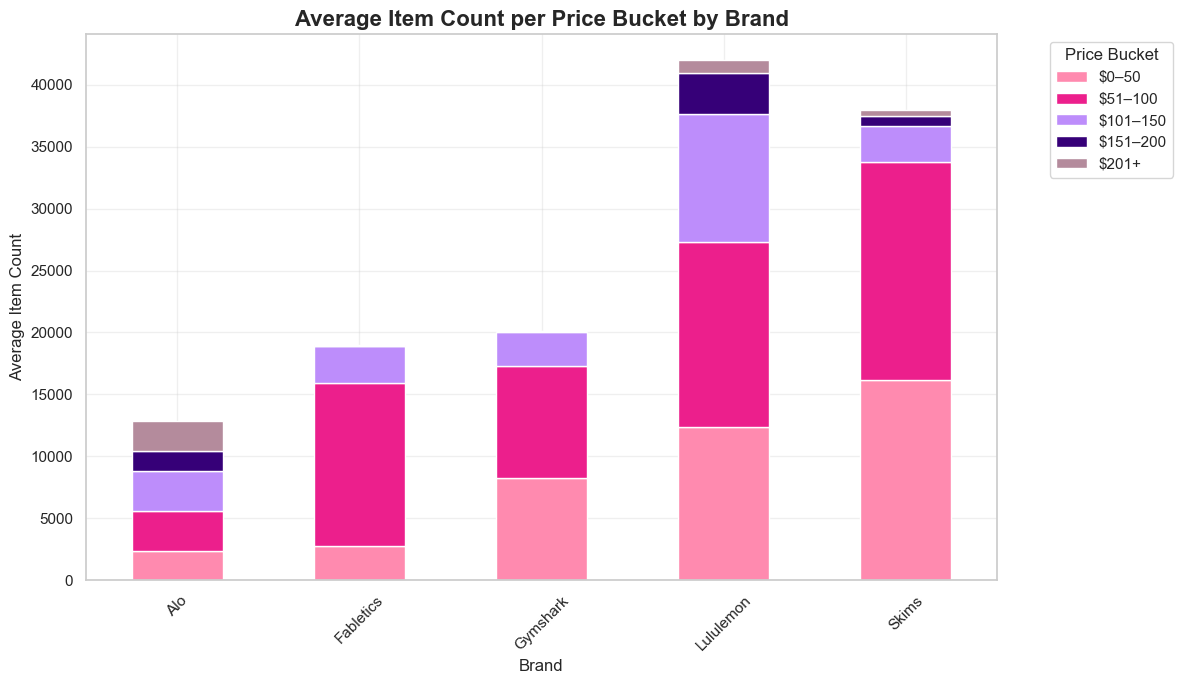

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    style='whitegrid',
    rc={'axes.facecolor': '#ffffff', 'grid.alpha': 0.3}
)

# 🎨 Defining  custom color palette for branding
custom_palette = ["#FF8AAF", "#EC1F8C", "#BD8DFB", "#360078", "#B48B9C"]
# Apply palette globally
sns.set_palette(custom_palette)

# Plot settings
plt.figure(figsize=(12, 7))
pivot.plot(kind='bar', stacked=True, figsize=(12, 7))

plt.title("Average Item Count per Price Bucket by Brand", fontsize=16, fontweight='bold')
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Average Item Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Price Bucket", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()